In [1]:
import numpy as np
import batman

In [42]:
def transit_model(time, t0, per, rp, a, inc, ecc, w, u1, u2):
    params = batman.TransitParams()                      #object to store transit parameters
    params.t0 = t0                                       #time of inferior conjunction
    params.per = per                                     #orbital period
    params.rp = rp                                       #planet radius (in units of stellar radii)
    params.a = a                                         #semi-major axis (in units of stellar radii)
    params.inc = inc                                     #orbital inclination (in degrees)
    params.ecc = ecc                                     #eccentricity
    params.w = w                                         #longitude of periastron (in degrees)
    params.limb_dark = "quadratic"                       #limb darkening model
    params.u = [u1, u2]                                  #limb darkening coefficients

    m = batman.TransitModel(params, time)                #initializes model
    flux = m.light_curve(params)
    t_secondary = m.get_t_secondary(params)
    anom       = m.get_true_anomaly()                    # anom is in radian!
    return flux, t_secondary, anom

def eclipse(time, t0, per, rp, a, inc, ecc, w, u1, u2, fp, t_sec):
    params = batman.TransitParams()                      #object to store transit parameters
    params.t0 = t0                                       #time of inferior conjunction
    params.per = per                                     #orbital period
    params.rp = rp                                       #planet radius (in units of stellar radii)
    params.a = a                                         #semi-major axis (in units of stellar radii)
    params.inc = inc                                     #orbital inclination (in degrees)
    params.ecc = ecc                                     #eccentricity
    params.w = w                                         #longitude of periastron (in degrees)
    params.limb_dark = "quadratic"                       #limb darkening model
    params.u = [u1, u2]                                  #limb darkening coefficients
    params.fp = fp                                       #planet/star brightnes
    params.t_secondary = t_sec
    
    m = batman.TransitModel(params, time, transittype="secondary")  #initializes model
    flux = m.light_curve(params)
    return flux

def area(time, t_sec, per, rp, inc_raw, r2):
    t = time - t_sec
    w = 2*np.pi/per    # orbital angular frequency not to be confused with argumnent of periastron
    phi = (w*t-np.pi)%(2*np.pi)
    inc = inc_raw*np.pi/180 #converting inclination to degrees
    #R = np.array([[np.sin(inc)*np.cos(phi),   np.sin(phi),  np.cos(inc)*np.cos(phi)],
    #              [-np.sin(inc)*np.sin(phi),  np.cos(phi),  -np.cos(inc)*np.sin(phi)],
    #              [-np.cos(inc),              0,            np.sin(inc)]])
    R = np.zeros((len(phi),3,3))
    R[:,0,0] = np.sin(inc)*np.cos(phi)
    R[:,0,1] = np.sin(phi)
    R[:,0,2] = np.cos(inc)*np.cos(phi)
    R[:,1,0] = -np.sin(inc)*np.sin(phi)
    R[:,1,1] = np.cos(phi)
    R[:,1,2] = -np.cos(inc)*np.sin(phi)
    R[:,2,0] = -np.cos(inc)
    R[:,2,2] = np.sin(inc)
    a_mat = np.array([[1/r2**2,  0,        0],
                      [0,        1/rp**2,  0],
                      [0,        0,        1/rp**2]])[np.newaxis,:,:]
    #[[a, d, f],
    # [_, b, e],
    # [_, _, c]] 
    arr = np.matmul(R.transpose(0,2,1), np.matmul(a_mat,R))
    a = arr[:,0,0]
    b = arr[:,1,1]
    c = arr[:,2,2]
    d = arr[:,0,1]
    e = arr[:,1,2]
    f = arr[:,0,2]
    return np.pi/np.sqrt(3*b*f**2/a + 3*c*d**2/a + -6*d*e*f/a + b*c - e**2)/(np.pi*rp**2)

def phase_variation(time, t_sec, per, anom, w, A, B, C, D, mode):
    if 'eccent' in mode:
        phi  = anom + np.deg2rad(w) + np.pi/2      # phis = orbital phase (everything in rad!)
    else:
        t    = time - t_sec
        freq = 2*np.pi/per
        phi  = (freq*t)
    if 'v2' in mode:
        phase = 1 + A*(np.cos(phi)-1) + B*np.sin(phi) + C*(np.cos(2*phi)-1) + D*np.sin(2*phi)
    else:
        phase = 1 + A*(np.cos(phi)-1) + B*np.sin(phi)
    return phase

def fplanet_model(time, anom, t0, per, rp, a, inc, ecc, w, u1, u2, fp, t_sec, A, B, C, D, r2, mode):
    phase = phase_variation(time, t_sec, per, anom, w, A, B, C, D, mode)
    eclip = eclipse(time, t0, per, rp, a, inc, ecc, w, u1, u2, fp, t_sec)
    if 'ellipse' in mode:
        return phase*(eclip - 1)*area(time, t_sec, per, rp, inc, r2)
    else:
        return phase*(eclip - 1)

def ideal_lightcurve(time, t0, per, rp, a, inc, ecosw, esinw, q1, q2, fp, A, B, C, D, r2, mode):
    
    ecc = np.sqrt(ecosw**2 + esinw**2)
    w   = np.rad2deg(np.arctan2(esinw, ecosw))    # needs to be in degrees for batman!
    u1  = 2*np.sqrt(q1)*q2
    u2  = np.sqrt(q1)*(1-2*q2)
    # create transit first and use orbital paramater to get time of superior conjunction
    transit, t_sec, anom = transit_model(time, t0, per, rp, a, inc, ecc, w, u1, u2)
    
    #ugly way of doing this as might pick up detector parameters, but thats alright - faster this way and still safe
    fplanet = fplanet_model(time, anom, t0, per, rp, a, inc, ecc, w, u1, u2, fp, t_sec, A, B, C, D, r2, mode)
    
    # add both light curves
    f_total = transit + fplanet
    return f_total



In [87]:
time = np.linspace(56394.88595585371,56398.5002979537, 10000)

mode     = 'Poly2_v1_eccent_psfw'

# Some definition for XO-3b
r_star            = 1.377                    # for XO-3 in solar radius
r_sol2jup         = 0.10049                  # jupiter radius in solar radius
r_sol2AU          = 214.93946938             # AU radius in solar radius

r2=1

# Personalize object default object values
#name = planet                          # name of the planet
    
t0   = 56418.540                       # BMJD time
per  = 3.1915239                       # in days
rp   = 0.125/r_star                    # planetary radius (in solar radius)/stellar radius (solar radius) 
a    = 0.0454*r_sol2AU/r_star          # 
inc  = 84.20                           # 90 = edge-on                
ecosw= 0.277*np.cos(np.deg2rad(347.2)) # ecc and w from (Wong et aL. 2014) # np.cos only takes rad
esinw= 0.277*np.sin(np.deg2rad(347.2)) # ecc and w from (Wong et aL. 2014) # np.sin only takes rad
ecc  = 0
anom = 0
q1   = 0.001
q2   = 0.001
fp   = 0.001                           # eclipse depth in units of stellar flux
    
A    = 0.1
B    = 0.0
C=0.0
D=0.0

u1  = 2*np.sqrt(q1)*q2
u2  = np.sqrt(q1)*(1-2*q2)

ecc = np.sqrt(ecosw**2 + esinw**2)
w   = np.rad2deg(np.arctan2(esinw, ecosw))

In [88]:
from astropy.time import Time
times = ['2013-04-14T04:52:00']
t = Time(times, format='isot', scale='utc')
t.mjd 

array([56396.20277778])

In [89]:
flux = ideal_lightcurve(time, t0, per, rp, a, inc, ecosw, esinw, q1, q2, fp, A, B, C, D, r2, mode)

In [90]:
import matplotlib.pyplot as plt
%matplotlib inline

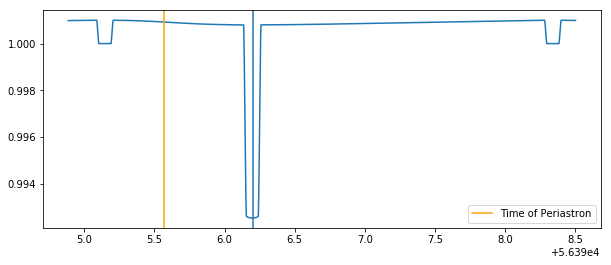

In [98]:
plt.figure(figsize=(10,4))
plt.plot(time, flux)
plt.axvline(x=56396.20277778)
plt.axvline(x=time[1898], color='orange', label='Time of Periastron')
plt.legend()

In [92]:
tflux, t_secondary, anom = transit_model(time, t0, per, rp, a, inc, ecc, w, u1, u2)

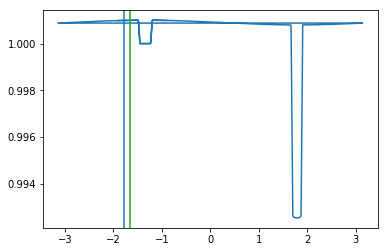

In [93]:
plt.figure()
plt.plot(anom, flux)
plt.axvline(x=anom[190])
plt.axvline(x=anom[363], color='C2')

In [96]:
diff = np.abs(anom)

In [97]:
np.argmin(diff)

1898

In [99]:
time[1898]

56395.57202659136